In [92]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

import tensorflow

from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard as TensorBoardCallback

# Fashion Classification

<img src="https://raw.githubusercontent.com/roma-glushko/zelando-fashion-mnist/master/doc/fashion-mnist.png" width="600px" />

In [2]:
RANDOM_SEED = 20210116

np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)

In [3]:
train_df = pd.read_csv('data/fashion-mnist_train.csv')
test_df = pd.read_csv('data/fashion-mnist_test.csv')

# Dataset Overview

In [4]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train, y_train = train_df.drop(['label'], axis=1), train_df['label']
X_test, y_test = test_df.drop(['label'], axis=1), test_df['label']

<AxesSubplot:xlabel='label', ylabel='Count'>

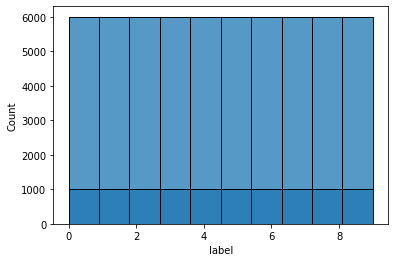

In [55]:
sns.histplot(data=y_train, bins=10)
sns.histplot(data=y_test, bins=10)

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_idx, val_idx in splitter.split(X_train, y_train):
    X_train_val, y_train_val = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

In [97]:
label_names = [
    'T-shirt/Top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]

label_num = len(label_name)

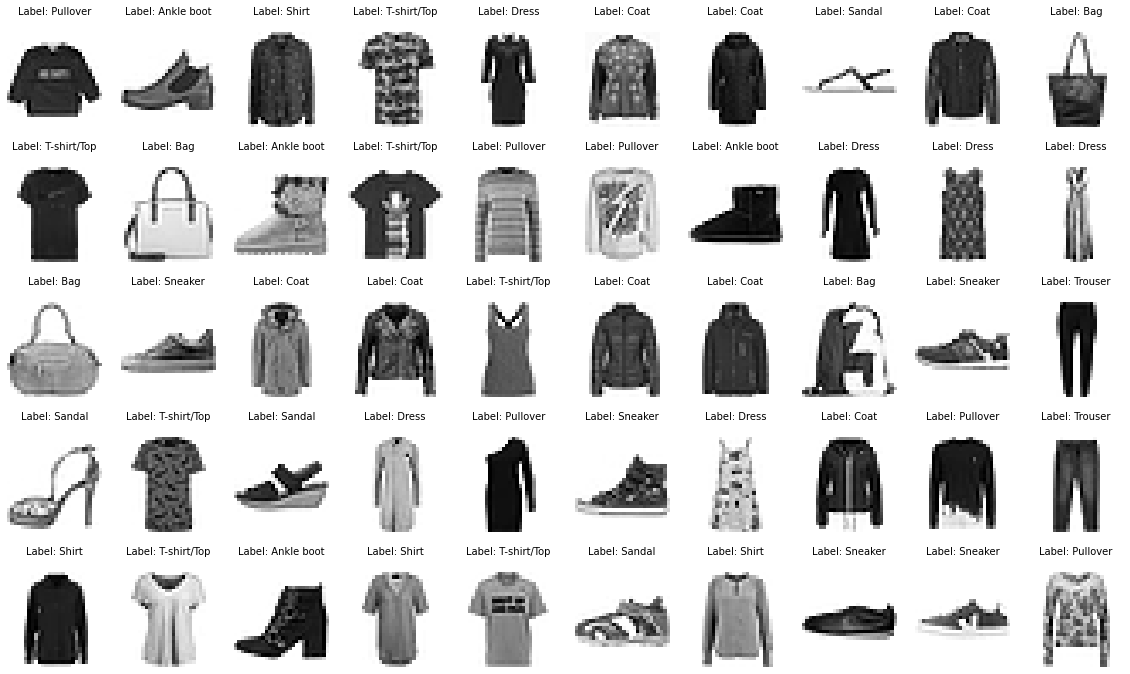

In [9]:
plt.figure(figsize=(20, 12))

for index, (image, label_idx) in enumerate(zip(X_train[0:50], y_train[0:50])):
    label = label_names[label_idx]

    ax = plt.subplot(5, 10, index + 1)
    ax.axis('off')

    plt.imshow(np.reshape(X_train.values[index], (28, 28)), cmap='binary')

    plt.title('Label: %s\n' % label, fontsize=10);

# Classification

In [118]:
def plot_confusion_matrix_by_predictions(y_true, y_predicted, *, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None, colorbar=False,
                          cmap='rocket_r', ax=None):
    
    cm = confusion_matrix(y_true, y_predicted, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_predicted)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format, colorbar=colorbar)


In [69]:
def get_log_dir():
    training_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(os.curdir, 'logs', training_id)

In [70]:
input_layer = Input((784))

x = Dense(300, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

output_layer = Dense(label_num, activation = 'softmax')(x)

model = Model(input_layer, output_layer)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dense_5 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 268,210
Trainable params: 267,410
Non-trainable params: 800
___________________________________________________

In [72]:
optimizer = Adam(lr=0.0005)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

In [73]:
early_stopping_callback = EarlyStopping(patience=15, restore_best_weights=True)
tensorboard_callback = TensorBoardCallback(
    get_log_dir(), histogram_freq=1, write_graph=True, write_images=True
)

training_history = model.fit(
    X_train_val, y_train_val, 
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stopping_callback, tensorboard_callback]
)

Epoch 1/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5988 - accuracy: 0.7900 - val_loss: 0.4230 - val_accuracy: 0.8404
Epoch 2/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3947 - accuracy: 0.8564 - val_loss: 0.3729 - val_accuracy: 0.8637
Epoch 3/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3578 - accuracy: 0.8684 - val_loss: 0.4015 - val_accuracy: 0.8509
Epoch 4/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3463 - accuracy: 0.8748 - val_loss: 0.3366 - val_accuracy: 0.8769
Epoch 5/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3147 - accuracy: 0.8839 - val_loss: 0.3311 - val_accuracy: 0.8793
Epoch 6/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2999 - accuracy: 0.8906 - val_loss: 0.3529 - val_accuracy: 0.8727
Epoch 7/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2951 - accuracy: 0.8912 - val_loss: 0.3466 - val_accuracy:

## Evaluation

In [59]:
## Dense(300, activation='relu'), Dense(100, activation='relu'), SGD
# Best Val Loss: 0.3154
# Best Val Accuracy: 0.8987
# Best Test Loss: 0.3189171850681305
# Best Test Accuracy: 0.8956999778747559

## Dense(300, activation='relu'), Dense(100, activation='relu'), Adam(lr=0.0005)
# Best Val Loss: 0.3054
# Best Val Accuracy: 0.8972
# Best Test Loss: 0.31720462441444397
# Best Test Accuracy: 0.8913999795913696

## Dense(300, activation='relu'), BatchNorm(), Dense(100, activation='relu'), BatchNorm(), Adam(lr=0.0005)
# Best Val Loss: 0.3020
# Best Val Accuracy: 0.8958
# Best Test Loss: 0.33810487389564514
# Best Test Accuracy: 0.8925999999046326

Best Val Loss: 0.3020
Best Val Accuracy: 0.8958


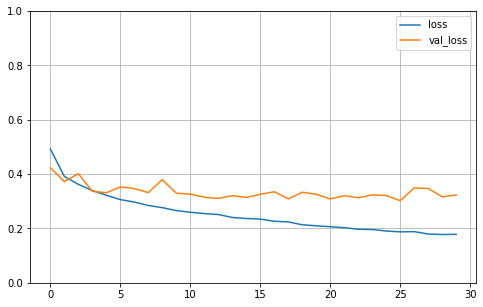

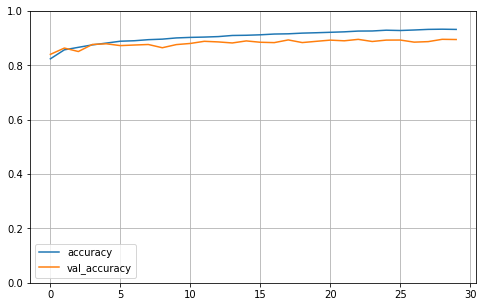

In [74]:
training_history_df = pd.DataFrame(training_history.history)

training_history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

training_history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

print(("Best Val Loss: {:0.4f}" +\
      "\nBest Val Accuracy: {:0.4f}")\
      .format(training_history_df['val_loss'].min(), 
              training_history_df['val_accuracy'].max()))

In [75]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3381 - accuracy: 0.8926


[0.33810487389564514, 0.8925999999046326]

In [86]:
y_test_pred = np.argmax(model.predict(X_test), axis=-1)

Test Report
              precision    recall  f1-score   support

           0     0.8346    0.8480    0.8413      1000
           1     0.9600    0.9850    0.9724      1000
           2     0.7654    0.8840    0.8204      1000
           3     0.9344    0.8690    0.9005      1000
           4     0.8519    0.8050    0.8278      1000
           5     0.9683    0.9470    0.9575      1000
           6     0.7555    0.7200    0.7373      1000
           7     0.9397    0.9500    0.9448      1000
           8     0.9856    0.9610    0.9732      1000
           9     0.9466    0.9570    0.9518      1000

    accuracy                         0.8926     10000
   macro avg     0.8942    0.8926    0.8927     10000
weighted avg     0.8942    0.8926    0.8927     10000



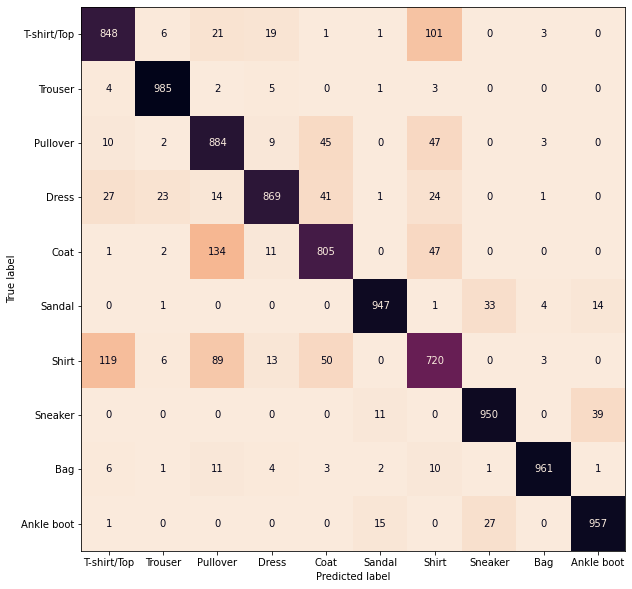

In [123]:
print('Test Report')
print(classification_report(y_test, y_test_pred, digits=4))

matrix = plot_confusion_matrix_by_predictions(y_test, y_test_pred, display_labels=label_names)
matrix.figure_.set_figheight(10)
matrix.figure_.set_figwidth(10)

In [186]:
missclass_label_indices = [
    idx for idx, (label_true, label_pred) in enumerate(zip(y_test, y_test_pred)) 
    if label_true == 4 and label_pred == 2
]

missclass_len = len(missclass_label_indices)

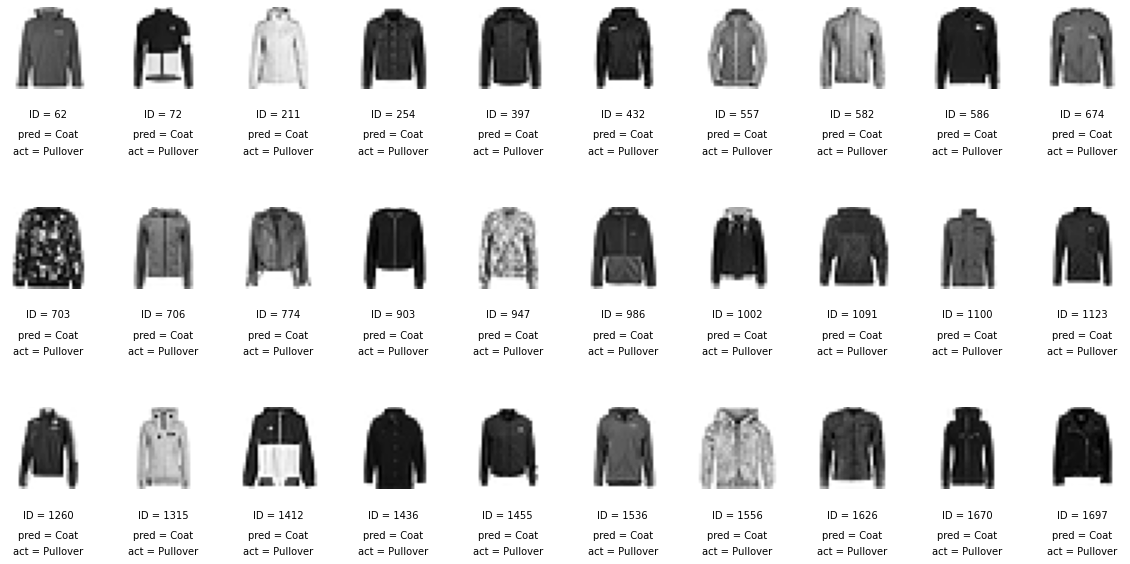

In [189]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(missclass_label_indices[:30]):    
    ax = fig.add_subplot(3, 10, i + 1)
    ax.axis('off')

    ax.text(0.5, -0.35, 'ID = ' + str(idx), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.6, 'pred = ' + label_names[y_test[idx]], fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.8, 'act = ' + label_names[y_test_pred[idx]], fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(np.reshape(X_test.values[idx], (28, 28)), cmap='binary')